## **Using DQN**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
df = pd.read_csv("metrics-with-output.csv")
df

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [3]:
# Menampilkan baris pertama dr dataset
df.head()

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0


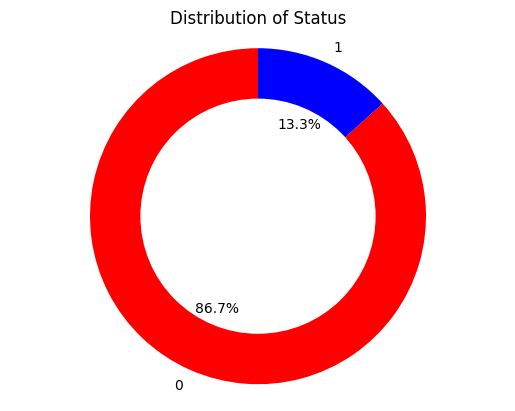

In [4]:
import matplotlib.pyplot as plt

#Membandingkan jumlah status Healthy dan Unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red','blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Distribution of Status')
plt.show()

In [5]:
# Preprocessing data
# Konversi dataset
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype('float') / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype('float') / 100.0
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype('float')
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype('float')
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [6]:
# Info dataset mengenai tipe, jumlah kolom dll
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB


In [7]:
# Menampilkan dataset setelah proses konversi dan pembersihan data
print(df)

                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110570000      0.202         0.553   
3     2023-09-08 01:16:15  1694110575000      0.146         0.580   
4     2023-09-08 01:16:20  1694110580000      0.102         0.535   
...                   ...            ...        ...           ...   
7184  2023-09-08 11:14:40  1694146480000      0.222         0.535   
7185  2023-09-08 11:14:45  1694146485000      0.272         0.560   
7186  2023-09-08 11:14:50  1694146490000      0.072         0.541   
7187  2023-09-08 11:14:55  1694146495000      0.234         0.546   
7188  2023-09-08 11:15:00  1694146500000      0.310         0.538   

      bandwidth_inbound  bandwidth_outbound  tps  tps_error  response_time  \
0                  7.46                6.45  2.0        0.0          0.607   
1              

In [8]:
# Pembersihan/Penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)

dataset.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode 'Status' column into numeric values
label_encoder = LabelEncoder()
dataset['Status'] = label_encoder.fit_transform(dataset['Status'])

In [10]:
dataset['Status']

0       0
1       0
2       0
3       0
4       0
       ..
7184    0
7185    0
7186    0
7187    0
7188    0
Name: Status, Length: 7189, dtype: int64

In [11]:
# Periksa apakah ada data yang hilang
missing_data = dataset.isnull().sum()
if missing_data.any():
    print("Data terdapat missing values yang perlu diimputasi:")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset.")

Tidak ada missing values dalam dataset.


In [12]:
# Split data menjadi features (X) dan target (y)
X = dataset.drop('Status', axis=1)
y = dataset['Status']

In [13]:
# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
# Definisikan Environment Class
class Environment:
    def __init__(self, dataset):
        self.dataset = dataset
        self.num_samples = len(dataset)
        self.current_sample_idx = None  # Set indeks sampel saat ini ke None saat inisialisasi

    def reset(self):
        self.current_sample_idx = 0  # Set ulang indeks sampel saat memulai episode baru
        return self.dataset.iloc[self.current_sample_idx], 0, False

    def step(self, action):
        self.current_sample_idx = (self.current_sample_idx + 1) % self.num_samples
        next_observation = self.dataset.iloc[self.current_sample_idx]
        reward = self.calculate_reward(next_observation, action)  # Hitung reward berdasarkan observasi dan aksi
        done = self.current_sample_idx == 0  # Atur done menjadi True jika mencapai akhir episode
        return next_observation, reward, done

    def calculate_reward(self, observation, action):
        actual_Status = observation['Status']  # Dapatkan nilai aktual dari Status dari observasi
        predicted_Status = action  # Mengasumsikan bahwa aksi adalah prediksi Status oleh agen
        if predicted_Status == actual_Status:
            reward = 1  # Beri reward positif jika prediksi Status cocok dengan Status aktual
        else:
            reward = 0  # Beri reward nol jika prediksi Status tidak cocok dengan Status aktual
        return reward

In [16]:
import tensorflow as tf  # Tambahkan import TensorFlow

# Define the Deep Q-Network agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # Meningkatkan gamma untuk meningkatkan pengaruh reward di masa depan
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001  # Mengurangi epsilon minimum untuk lebih banyak eksplorasi
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0001  # Menurunkan tingkat pembelajaran
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [17]:
# Parameters
num_actions = 2  # Number of possible actions
num_features = len(dataset.columns) - 1  # Number of features in the dataset (excluding classification)
batch_size = 40
num_episodes = 1800
max_steps = 2000

In [18]:
# Initialize environment and agent
env = Environment(dataset)
agent = DQNAgent(state_size=num_features, action_size=num_actions)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Training loop
total_reward_all = 0
for episode in range(num_episodes):
    state, _, _ = env.reset()  # Reset the environment and get initial state
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)  # Take action and get next state, reward, and done status
        agent.remember(state, action, reward, next_state, done)  # Remember the experience
        state = next_state  # Update the current state
        total_reward += reward  # Accumulate total reward for the episode
    total_reward_all += total_reward
    print("Episode:", episode+1, "of", num_episodes, "Total Reward:", total_reward)

Episode: 1 of 1800 Total Reward: 3594
Episode: 2 of 1800 Total Reward: 3627
Episode: 3 of 1800 Total Reward: 3644
Episode: 4 of 1800 Total Reward: 3533
Episode: 5 of 1800 Total Reward: 3569
Episode: 6 of 1800 Total Reward: 3603
Episode: 7 of 1800 Total Reward: 3585
Episode: 8 of 1800 Total Reward: 3603
Episode: 9 of 1800 Total Reward: 3613
Episode: 10 of 1800 Total Reward: 3591
Episode: 11 of 1800 Total Reward: 3602
Episode: 12 of 1800 Total Reward: 3639
Episode: 13 of 1800 Total Reward: 3564
Episode: 14 of 1800 Total Reward: 3535
Episode: 15 of 1800 Total Reward: 3581
Episode: 16 of 1800 Total Reward: 3649
Episode: 17 of 1800 Total Reward: 3616
Episode: 18 of 1800 Total Reward: 3617
Episode: 19 of 1800 Total Reward: 3620
Episode: 20 of 1800 Total Reward: 3578
Episode: 21 of 1800 Total Reward: 3548
Episode: 22 of 1800 Total Reward: 3666
Episode: 23 of 1800 Total Reward: 3679
Episode: 24 of 1800 Total Reward: 3539
Episode: 25 of 1800 Total Reward: 3589
Episode: 26 of 1800 Total Reward: 

In [20]:
# Calculate average reward
average_reward = total_reward_all / num_episodes
print("Average reward:", average_reward)

Average reward: 3594.6277777777777


In [21]:
# Function to predict Status
def predict_status(observation, agent):
    state = observation.values[:-1]  # Menggunakan fitur dari observasi sebagai state
    state = np.reshape(state, (1, len(state)))  # Reshape state menjadi bentuk (1, num_features)
    action = agent.act(state)  # Prediksi tindakan menggunakan agen
    return action  # Mengembalikan aksi sebagai prediksi Status

In [22]:
# Contoh prediksi Status berdasarkan observasi ke-10 dari dataset
observation = dataset.iloc[10]  # Ambil observasi ke-10 dari dataset
predicted_status = predict_status(observation, agent)  # Prediksi Status menggunakan fungsi predict_status
actual_status = observation['Status']  # Status yang sebenarnya dari observasi dalam dataset
print("Predicted Status for observation 10:", predicted_status)
print("Actual Status for observation 10:", actual_status)

Predicted Status for observation 10: 1
Actual Status for observation 10: 0.0


In [23]:
# Fungsi untuk hitung akurasi
def calculate_accuracy(dataset, agent):
    correct_predictions = 0
    total_predictions = len(dataset)

    for index, observation in dataset.iterrows():
        state = observation.values[:-1]  # Menggunakan fitur dari observasi sebagai state
        predicted_Status = agent.act(state)  # Prediksi Status menggunakan agen
        actual_Status = observation['Status']  # Nilai Status aktual dari dataset
        if predicted_Status == actual_Status:
            correct_predictions += 1

    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

In [24]:
# Menggunakan fungsi calculate_accuracy untuk menghitung akurasi
accuracy = calculate_accuracy(dataset, agent)
print("Accuracy:", accuracy, "%")

Accuracy: 49.993044929753786 %


In [25]:
# Membuat list untuk menyimpan hasil prediksi
predicted_labels = []

In [26]:
# Loop melalui setiap observasi dalam dataset dan membuat prediksi
for index, observation in dataset.iterrows():
    predicted_status = predict_status(observation, agent)  # Melakukan prediksi Status
    predicted_labels.append(predicted_status)

In [27]:
# Membuat DataFrame dari list hasil prediksi
predicted_labels_df = pd.DataFrame(predicted_labels, columns=['Status'])

In [28]:
# Output hasil prediksi dalam format yang diminta
print(predicted_labels_df)

      Status
0          1
1          1
2          0
3          0
4          1
...      ...
7184       1
7185       0
7186       0
7187       0
7188       1

[7189 rows x 1 columns]


In [29]:
# Gabungkan kolom Status dari dataset asli dengan kolom Status dari predicted_labels_df
comparison_df = pd.concat([dataset['Status'], predicted_labels_df['Status']], axis=1)
comparison_df.columns = ['Actual_Status', 'Predicted_Status']

In [30]:
# Hitung jumlah status yang sama dan yang berbeda
same_status = comparison_df[comparison_df['Actual_Status'] == comparison_df['Predicted_Status']].shape[0]
different_status = comparison_df[comparison_df['Actual_Status'] != comparison_df['Predicted_Status']].shape[0]

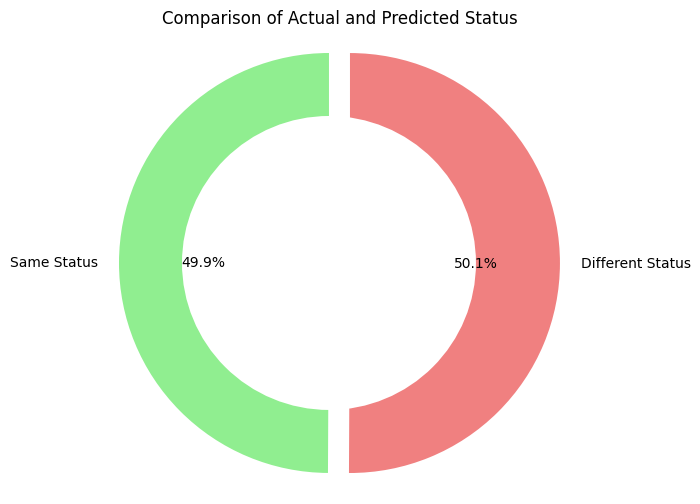

In [31]:
# Buat visualisasi
plt.figure(figsize=(8, 6))
labels = ['Same Status', 'Different Status']
sizes = [same_status, different_status]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)  # Pisahkan "Different Status"
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Comparison of Actual and Predicted Status')
plt.show()

In [32]:
import matplotlib.pyplot as plt

# Hitung jumlah status 0 dan 1 dari predicted_labels_df
healthy_count = predicted_labels_df[predicted_labels_df['Status'] == 0].shape[0]
unhealthy_count = predicted_labels_df[predicted_labels_df['Status'] == 1].shape[0]

In [33]:
# Data untuk plot
status_labels = ['0', '1']
status_counts = [healthy_count, unhealthy_count]

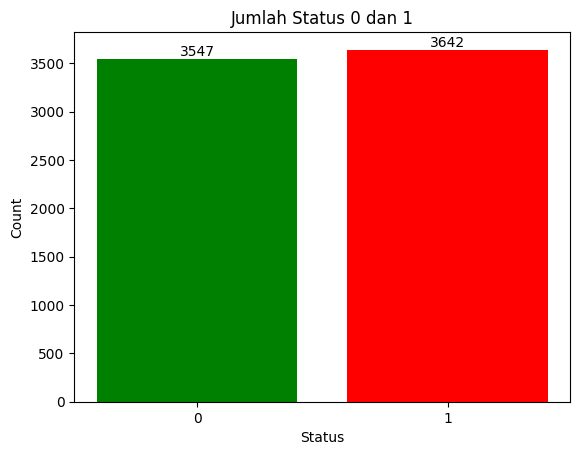

In [34]:
# Plot batang
plt.bar(status_labels, status_counts, color=['green', 'red'])

# Tambahkan label angka di atas setiap batang
for i in range(len(status_labels)):
    plt.text(i, status_counts[i], str(status_counts[i]), ha='center', va='bottom')

# Label sumbu dan judul
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Jumlah Status 0 dan 1')

# Tampilkan plot
plt.show()

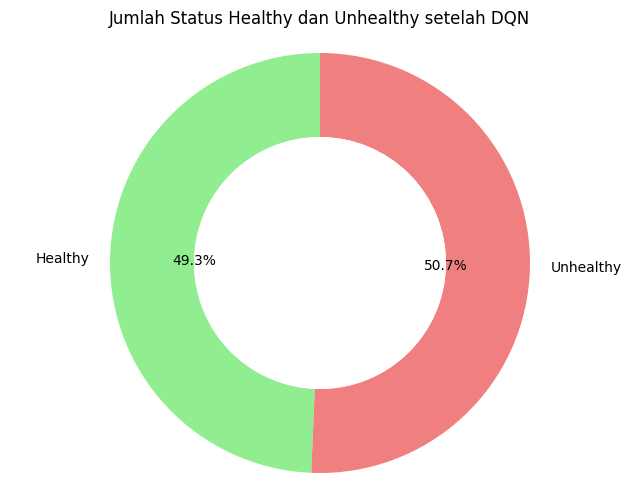

In [35]:
import matplotlib.pyplot as plt

# Hitung jumlah status 0 dan 1 dari predicted_labels_df
healthy_count = predicted_labels_df[predicted_labels_df['Status'] == 0].shape[0]
unhealthy_count = predicted_labels_df[predicted_labels_df['Status'] == 1].shape[0]

# Data untuk plot
status_labels = ['Healthy', 'Unhealthy']
status_counts = [healthy_count, unhealthy_count]
colors = ['lightgreen', 'lightcoral']

# Plot donut chart
plt.figure(figsize=(8, 6))
plt.pie(status_counts, labels=status_labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
plt.gca().add_artist(plt.Circle((0, 0), 0.6, fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Jumlah Status Healthy dan Unhealthy setelah DQN')
plt.show()

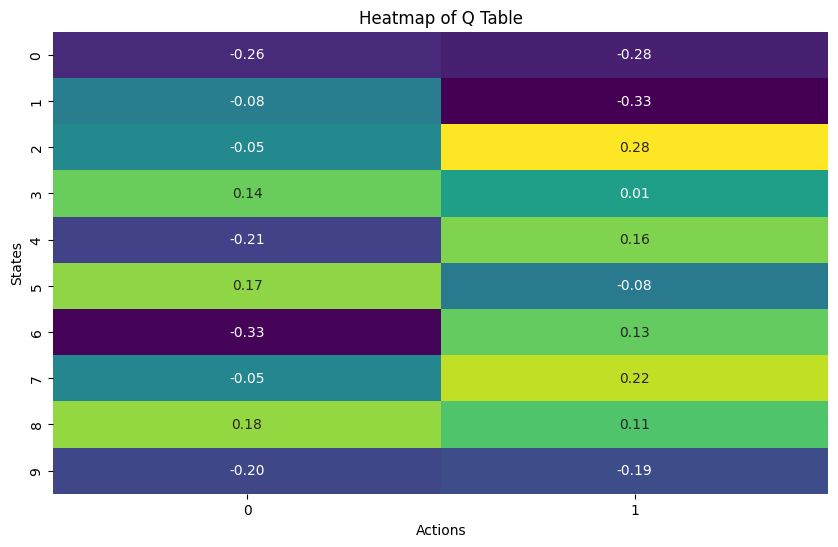

In [36]:
# Menampilkan heatmap dari tabel Q
import seaborn as sns

# Dapatkan bobot dari model jaringan saraf
def get_q_table(model, num_actions):
    # Ambil layer ke-2 (indeks 1) dari model, yang merupakan layer pertama setelah input
    first_layer = model.layers[1]
    # Dapatkan bobot dari layer
    weights = first_layer.get_weights()[0]
    # Ubah bobot menjadi format yang sesuai untuk tabel Q
    q_table = weights.reshape((-1, num_actions))
    return q_table

# Fungsi untuk menampilkan heatmap dari tabel Q
def plot_q_table_heatmap(q_table):
    plt.figure(figsize=(10, 6))
    sns.heatmap(q_table, cmap='viridis', annot=True, fmt=".2f", cbar=False)
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('Heatmap of Q Table')
    plt.show()

# Dapatkan tabel Q dari model agen
q_table = get_q_table(agent.model, num_actions)

# Reduksi dimensi state labels menjadi 1-10
state_labels_reduced = ['State {}'.format(i+1) for i in range(10)]

# Ambil subset dari q_table untuk hanya menampilkan 10 state pertama
q_table_subset = q_table[:10]

# Tampilkan heatmap dari tabel Q
plot_q_table_heatmap(q_table_subset)

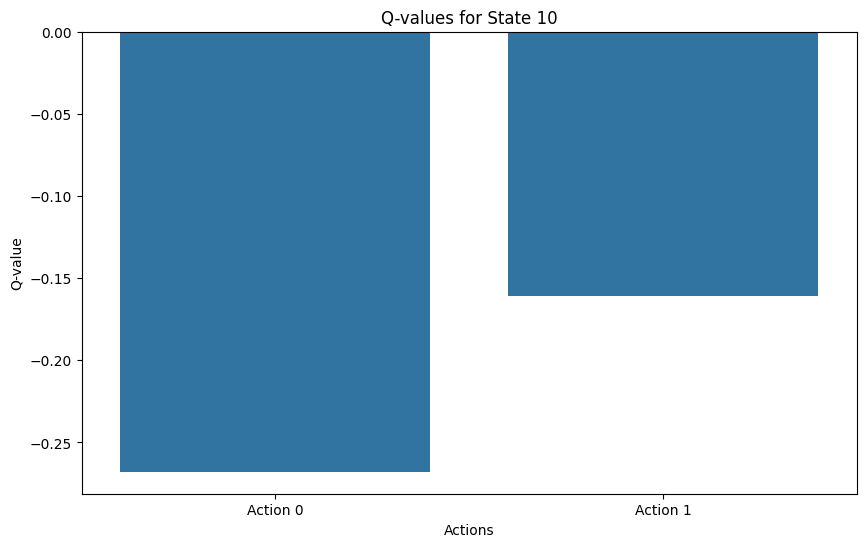

In [37]:
# Pilih state yang ingin divisualisasikan, misalnya state ke-10
state_index = 10

# Dapatkan Q-values untuk state tersebut
q_values = q_table[state_index, :]

# Tentukan actions (dalam kasus Anda, hanya 2 actions)
actions = ['Action 0', 'Action 1']

# Plot barplot dari Q-values
plt.figure(figsize=(10, 6))
sns.barplot(x=actions, y=q_values)
plt.title(f'Q-values for State {state_index}')
plt.xlabel('Actions')
plt.ylabel('Q-value')
plt.show()

Confusion Matrix - Validation Data
[[601 627]
 [ 99 111]]


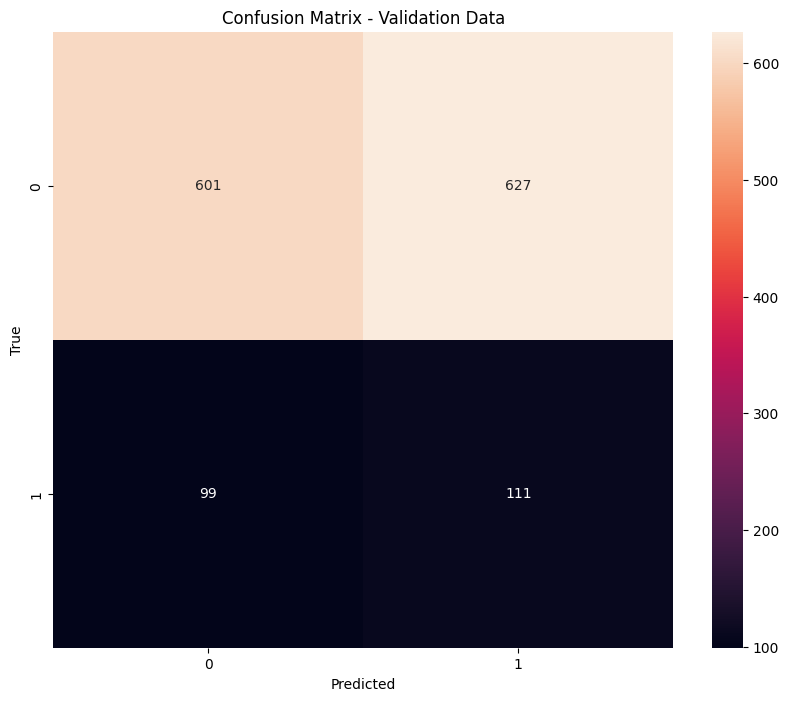

Classification Report - Validation Data


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Menghitung dan menampilkan confusion matrix untuk data validasi
cm_val = confusion_matrix(y_test, predicted_labels[:1438])
print("Confusion Matrix - Validation Data")
print(cm_val)

# Menampilkan confusion matrix sebagai heatmap untuk data validasi
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Menghitung dan menampilkan classification report untuk data validasi
print("Classification Report - Validation Data")
report_val = classification_report(y_test, predicted_labels[:1438])

## **Using PPO Stable Baseline**

In [ ]:
# Import Library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Load data
data = pd.read_csv(("metrics-with-output-ori.csv"))
data

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [ ]:
# Menampilkan baris pertama data
print(data.head())

                  Time      Timestamp cpu_usage memory_usage  \
0  2023-09-08 01:16:00  1694110560000     9.00%        53.5%   
1  2023-09-08 01:16:05  1694110565000     16.6%        53.3%   
2  2023-09-08 01:16:10  1694110570000     20.2%        55.3%   
3  2023-09-08 01:16:15  1694110575000     14.6%        58.0%   
4  2023-09-08 01:16:20  1694110580000     10.2%        53.5%   

  bandwidth_inbound bandwidth_outbound         tps tps_error response_time  \
0         7.46 GB/s          6.45 GB/s     2 req/s   0 req/s        607 ms   
1         5.85 GB/s          5.27 GB/s  2.20 req/s   0 req/s        2.09 s   
2         9.06 GB/s          7.96 GB/s  3.20 req/s   0 req/s        3.45 s   
3         8.41 GB/s          7.21 GB/s  3.20 req/s   0 req/s        2.58 s   
4         4.88 GB/s          4.30 GB/s  2.60 req/s   0 req/s        862 ms   

   Status  
0       0  
1       0  
2       0  
3       0  
4       0  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


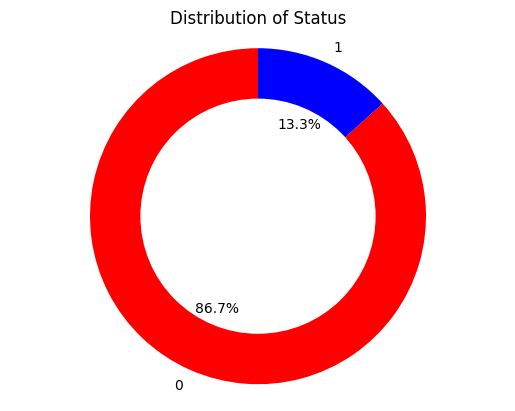

In [ ]:
import matplotlib.pyplot as plt

#Membandingkan jumlah status Healthy dan Unhealthy dengan donut chart
status_counts = data['Status'].value_counts()

colors = ['red','blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Distribution of Status')
plt.show()

In [ ]:
# Preprocessing

# Konversi Dataset
data['cpu_usage'] = data['cpu_usage'].str.rstrip('%').astype('float') / 100.0
data['memory_usage'] = data['memory_usage'].str.rstrip('%').astype('float') / 100.0

In [ ]:
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data['bandwidth_inbound'] = data['bandwidth_inbound'].apply(clean_bandwidth)
data['bandwidth_outbound'] = data['bandwidth_outbound'].apply(clean_bandwidth)
data['tps'] = data['tps'].str.rstrip(' req/s').astype('float')
data['tps_error'] = data['tps_error'].str.rstrip(' req/s').astype('float')
data['response_time'] = data['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [ ]:
# Menampilkan data setelah konversi
data.info()
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB
                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data = data.drop(data.columns[[0,1]], axis=1)
data.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [ ]:
# Preprocessing Data
from sklearn.preprocessing import LabelEncoder

#Mendefinisikan fitur dan label
features = data.drop(columns='Status')
labels = data['Status']

#Standarisasi fitur
# Encode 'Status' column into numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
scaler = StandardScaler()
features = scaler.fit_transform(features)

#Memisahkan data ke dalam set training dan test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Periksa apakah ada data yang hilang
missing_data = data.isnull().sum()
if missing_data.any():
    print("Data terdapat missing values yang perlu diimputasi:")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset.")

Tidak ada missing values dalam dataset.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Menginisialisasi CustomEnv
import gym as gym
from gym import spaces

class CustomEnv(gym.Env):
    def __init__(self, features, labels):
        super(CustomEnv, self).__init__()
        self.features = features
        self.labels = labels
        self.current_step = 0
        self.total_reward = 0
        self.episode_rewards = []

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # Assuming binary classification (healthy/unhealthy)

    def reset(self):
        self.current_step = 0
        self.total_reward = 0
        return self.features[self.current_step]

    def step(self, action):
        reward = 1 if action == self.labels[self.current_step] else -1
        self.total_reward += reward
        self.current_step += 1

        done = self.current_step >= len(self.features)
        if done:
            self.episode_rewards.append(self.total_reward)

        obs = self.features[self.current_step] if not done else np.zeros(self.features.shape[1])

        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        pass


In [ ]:
# Create environment
# env = DummyVecEnv([lambda: CustomEnv(X_train, y_train)])

env = DummyVecEnv([lambda: CustomEnv(X_train, y_train)])

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# Training Model
# Instantiate the PPO model
model = PPO('MlpPolicy', env, verbose=1, )

# Train the model
model.learn(total_timesteps=1800)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 674  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------


In [ ]:
# Mengevaluasi Model
def evaluate_model(model, X_test, y_test):
    predicted_statuses = []

    for obs in X_test:
        obs = np.array(obs).reshape(1, -1)
        action, _ = model.predict(obs)
        predicted_statuses.append(action[0])

    predicted_statuses = np.array(predicted_statuses)

    accuracy = np.mean(np.array(predicted_statuses) == y_test)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return predicted_statuses


In [ ]:
# Evaluate the model
predicted_statuses = evaluate_model(model, X_test, y_test)

Accuracy: 59.53%


   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       0          1
4       1          0


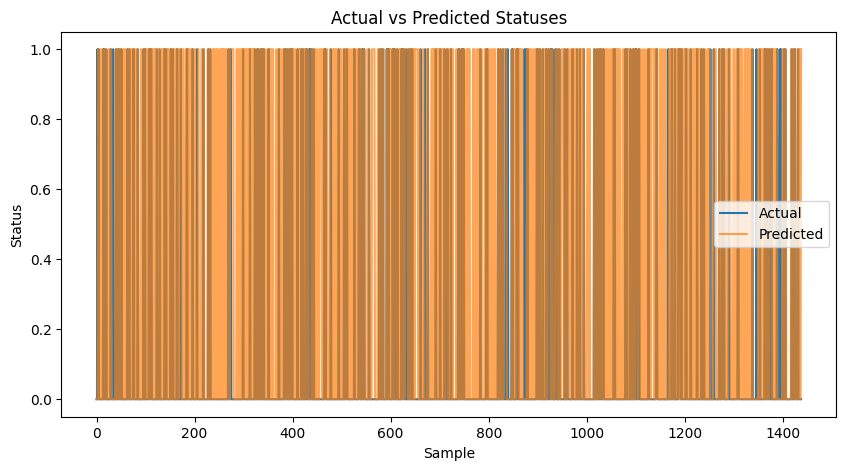

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted statuses
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_statuses})
print(comparison_df.head())

plt.figure(figsize=(10, 5))
plt.plot(comparison_df['Actual'].values, label='Actual')
plt.plot(comparison_df['Predicted'].values, label='Predicted', alpha=0.7)
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Status')
plt.title('Actual vs Predicted Statuses')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


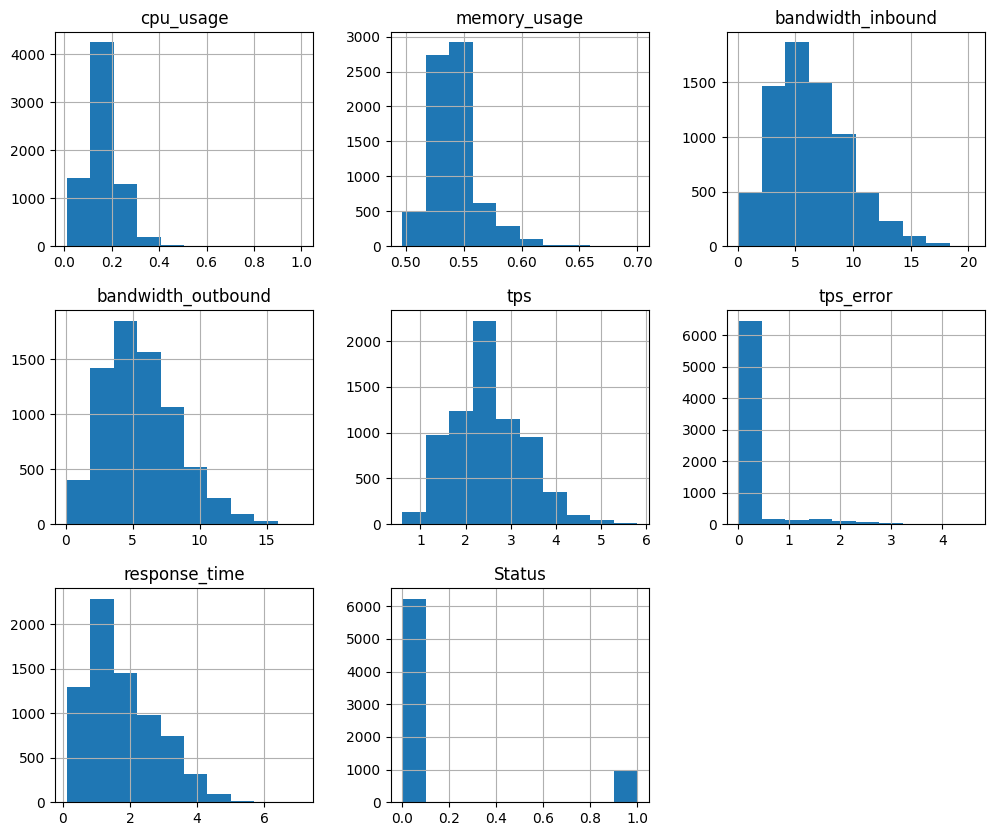

In [ ]:
data.hist(figsize=(12, 10))
plt.show()

In [ ]:
# Plot the episode rewards during training
model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Using PPO**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym as gym
from gym import spaces

In [ ]:
# Load dataset
df = pd.read_csv("D:\KULIAHHH\LULUS YOK\SKRIPSI\metrics-with-output.csv")
df

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [ ]:
# Menampilkan baris pertama dari data set
df.head()

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0


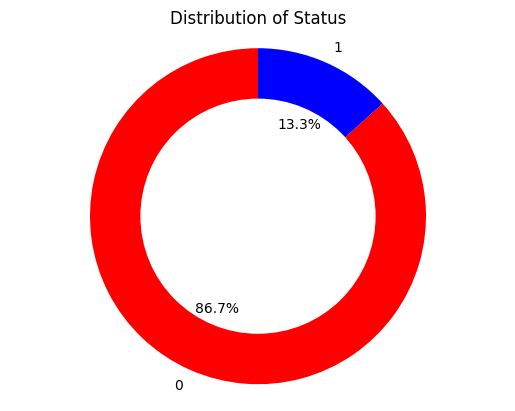

In [ ]:
import matplotlib.pyplot as plt

# Membandingkan jumlah status healthy dan unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red', 'blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
# menambahkan lingkaran tengah untuk membuat donut chart
plt.gca().add_artist(plt.Circle((0,0), 0.70, fc='white'))
# memastikan lingkaran berukuran sama sehingga terlihat seperti donus
plt.axis('equal')

plt.title('Distribution of Status')
plt.show()

In [ ]:
print(df.dtypes)

Time                  object
Timestamp              int64
cpu_usage             object
memory_usage          object
bandwidth_inbound     object
bandwidth_outbound    object
tps                   object
tps_error             object
response_time         object
Status                 int64
dtype: object


In [ ]:
# Preprocessing data
# Konversi dataset
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype(float) / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype('float') / 100.0
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype('float')
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype('float')
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [ ]:
# Info dataset mengenai tipe, jumlah kolom, dll
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB


In [ ]:
# Menampilkan dataset setelah konversi
print(df)

                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110570000      0.202         0.553   
3     2023-09-08 01:16:15  1694110575000      0.146         0.580   
4     2023-09-08 01:16:20  1694110580000      0.102         0.535   
...                   ...            ...        ...           ...   
7184  2023-09-08 11:14:40  1694146480000      0.222         0.535   
7185  2023-09-08 11:14:45  1694146485000      0.272         0.560   
7186  2023-09-08 11:14:50  1694146490000      0.072         0.541   
7187  2023-09-08 11:14:55  1694146495000      0.234         0.546   
7188  2023-09-08 11:15:00  1694146500000      0.310         0.538   

      bandwidth_inbound  bandwidth_outbound  tps  tps_error  response_time  \
0                  7.46                6.45  2.0        0.0          0.607   
1              

In [ ]:
# Pembersihan dan penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)
dataset.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode Status ke numerik
label_encoder = LabelEncoder()
dataset['Status'] = label_encoder.fit_transform(dataset['Status'])

In [ ]:
dataset['Status']

0       0
1       0
2       0
3       0
4       0
       ..
7184    0
7185    0
7186    0
7187    0
7188    0
Name: Status, Length: 7189, dtype: int64

In [ ]:
# Periksa apakah ada data yang hilang
missing_data = dataset.isnull().sum()
if missing_data.any():
    print("Terdapat missing values yang perlu diimputasi")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset")

Tidak ada missing values dalam dataset


In [ ]:
# Split data menjadi feature (X) dan target (y)
X = dataset.drop('Status', axis=1)
y = dataset['Status']

In [ ]:
# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Mendefinisikan model ppo
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class PPO:
    def __init__(self, state_dim, action_dim, lr=0.0003, gamma=0.99, k_epochs=4, eps_clip=0.2):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = PolicyNetwork(state_dim, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs = torch.softmax(self.policy_old(state), dim=-1)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item()
    
    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalisasi rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # Konversi list ke tensor
        old_states = torch.squeeze(torch.stack(memory.states, dim=0)).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions, dim=0)).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs, dim=0)).detach()
        # old_logprobs = torch.tensor(memory.logprobs).detach()
        # old_logprobs = torch.squeeze(torch.stack([torch.tensor(logprob) for logprob in memory.logprobs], dim=0)).detach()
        
        # Optimisasi policy:
        for _ in range(self.k_epochs):
            logprobs = []
            state_values = []
            dist_entropy = []
            for state in old_states:
                action_probs = torch.softmax(self.policy(state), dim=-1)
                dist = Categorical(action_probs)
                logprob = dist.log_prob(old_actions)
                entropy = dist.entropy()
                
                logprobs.append(logprob)
                dist_entropy.append(entropy)
            
            logprobs = torch.stack(logprobs)
            dist_entropy = torch.stack(dist_entropy)
            
            ratios = torch.exp(logprobs - old_logprobs)
            
            advantages = rewards - rewards.mean()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            state_values = torch.zeros_like(rewards)
            for i, state in enumerate(old_states):
                state_values[i] = self.policy(state).max()
            
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards)- 0.01*dist_entropy.mean()
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        self.policy_old.load_state_dict(self.policy.state_dict())

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

    def add_action(self, action):
        self.actions.append(action)

    def add_state(self, state):
        self.states.append(state)

    def add_logprob(self, logprob):
        self.logprobs.append(logprob)

    def add_reward(self, reward):
        self.rewards.append(reward)

    def add_is_terminal(self, is_terminal):
        self.is_terminals.append(is_terminal)


In [ ]:
# Mendefinisikan Environment
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()

        # Load data dari data set
        self.df = dataset

        # Mendefinisikan action dan observation space
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float64)

        self.curent_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_observation()
    
    def step(self, action):
        self.curent_step += 1
        done = self.curent_step >= len(self.df) - 1

        reward = self._get_reward(action)
        next_state = self._get_observation()
        
        return next_state, reward, done, {}
    
    def _get_observation(self):
        return self.df.iloc[self.current_step][['cpu_usage', 'memory_usage', 'bandwidth_inbound', 'bandwidth_outbound', 'tps', 'tps_error', 'response_time']].values
    
    def _get_reward(self, action):
        if self.df.iloc[self.current_step]['Status'] == 0:
            return 1.0
        else:
            return 0.0


In [ ]:
# Training Model PPO

env = CustomEnv()

# Use the custom environment with the PPO algorithm
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo = PPO(state_dim, action_dim)
memory = Memory()

max_episodes = 1800
max_timesteps = 2000
update_timestep = 2000
print_freq = 1

time_step = 0
episode_rewards = []

for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for t in range(max_timesteps):
        time_step += 1
        action, logprob = ppo.select_action(state)
        next_state, reward, done, _ = env.step(action)


        # memory.add_state(torch.FloatTensor(state))
        memory.add_state(torch.FloatTensor(state))
        memory.add_action(torch.tensor(action))
        memory.add_logprob(torch.tensor(logprob))
        memory.add_reward(reward)
        memory.add_is_terminal(done)
        
        state = next_state
        episode_reward += reward


        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0
        
        if done:
            break
    
    if episode % print_freq == 0:
        print("Episode {} \t Total reward: {}".format(episode, episode_reward))

    
        

Episode 1 	 Total reward: 2000.0
Episode 2 	 Total reward: 2000.0
Episode 3 	 Total reward: 2000.0
Episode 4 	 Total reward: 1188.0
Episode 5 	 Total reward: 1.0
Episode 6 	 Total reward: 1.0
Episode 7 	 Total reward: 1.0
Episode 8 	 Total reward: 1.0
Episode 9 	 Total reward: 1.0
Episode 10 	 Total reward: 1.0
Episode 11 	 Total reward: 1.0
Episode 12 	 Total reward: 1.0
Episode 13 	 Total reward: 1.0
Episode 14 	 Total reward: 1.0
Episode 15 	 Total reward: 1.0
Episode 16 	 Total reward: 1.0
Episode 17 	 Total reward: 1.0
Episode 18 	 Total reward: 1.0
Episode 19 	 Total reward: 1.0
Episode 20 	 Total reward: 1.0
Episode 21 	 Total reward: 1.0
Episode 22 	 Total reward: 1.0
Episode 23 	 Total reward: 1.0
Episode 24 	 Total reward: 1.0
Episode 25 	 Total reward: 1.0
Episode 26 	 Total reward: 1.0
Episode 27 	 Total reward: 1.0
Episode 28 	 Total reward: 1.0
Episode 29 	 Total reward: 1.0
Episode 30 	 Total reward: 1.0
Episode 31 	 Total reward: 1.0
Episode 32 	 Total reward: 1.0
Episo

Episode 333 	 Total reward: 1.0
Episode 334 	 Total reward: 1.0
Episode 335 	 Total reward: 1.0
Episode 336 	 Total reward: 1.0
Episode 337 	 Total reward: 1.0
Episode 338 	 Total reward: 1.0
Episode 339 	 Total reward: 1.0
Episode 340 	 Total reward: 1.0
Episode 341 	 Total reward: 1.0
Episode 342 	 Total reward: 1.0
Episode 343 	 Total reward: 1.0
Episode 344 	 Total reward: 1.0
Episode 345 	 Total reward: 1.0
Episode 346 	 Total reward: 1.0
Episode 347 	 Total reward: 1.0
Episode 348 	 Total reward: 1.0
Episode 349 	 Total reward: 1.0
Episode 350 	 Total reward: 1.0
Episode 351 	 Total reward: 1.0
Episode 352 	 Total reward: 1.0
Episode 353 	 Total reward: 1.0
Episode 354 	 Total reward: 1.0
Episode 355 	 Total reward: 1.0
Episode 356 	 Total reward: 1.0
Episode 357 	 Total reward: 1.0
Episode 358 	 Total reward: 1.0
Episode 359 	 Total reward: 1.0
Episode 360 	 Total reward: 1.0
Episode 361 	 Total reward: 1.0
Episode 362 	 Total reward: 1.0
Episode 363 	 Total reward: 1.0
Episode 

Episode 616 	 Total reward: 1.0
Episode 617 	 Total reward: 1.0
Episode 618 	 Total reward: 1.0
Episode 619 	 Total reward: 1.0
Episode 620 	 Total reward: 1.0
Episode 621 	 Total reward: 1.0
Episode 622 	 Total reward: 1.0
Episode 623 	 Total reward: 1.0
Episode 624 	 Total reward: 1.0
Episode 625 	 Total reward: 1.0
Episode 626 	 Total reward: 1.0
Episode 627 	 Total reward: 1.0
Episode 628 	 Total reward: 1.0
Episode 629 	 Total reward: 1.0
Episode 630 	 Total reward: 1.0
Episode 631 	 Total reward: 1.0
Episode 632 	 Total reward: 1.0
Episode 633 	 Total reward: 1.0
Episode 634 	 Total reward: 1.0
Episode 635 	 Total reward: 1.0
Episode 636 	 Total reward: 1.0
Episode 637 	 Total reward: 1.0
Episode 638 	 Total reward: 1.0
Episode 639 	 Total reward: 1.0
Episode 640 	 Total reward: 1.0
Episode 641 	 Total reward: 1.0
Episode 642 	 Total reward: 1.0
Episode 643 	 Total reward: 1.0
Episode 644 	 Total reward: 1.0
Episode 645 	 Total reward: 1.0
Episode 646 	 Total reward: 1.0
Episode 

Episode 890 	 Total reward: 1.0
Episode 891 	 Total reward: 1.0
Episode 892 	 Total reward: 1.0
Episode 893 	 Total reward: 1.0
Episode 894 	 Total reward: 1.0
Episode 895 	 Total reward: 1.0
Episode 896 	 Total reward: 1.0
Episode 897 	 Total reward: 1.0
Episode 898 	 Total reward: 1.0
Episode 899 	 Total reward: 1.0
Episode 900 	 Total reward: 1.0
Episode 901 	 Total reward: 1.0
Episode 902 	 Total reward: 1.0
Episode 903 	 Total reward: 1.0
Episode 904 	 Total reward: 1.0
Episode 905 	 Total reward: 1.0
Episode 906 	 Total reward: 1.0
Episode 907 	 Total reward: 1.0
Episode 908 	 Total reward: 1.0
Episode 909 	 Total reward: 1.0
Episode 910 	 Total reward: 1.0
Episode 911 	 Total reward: 1.0
Episode 912 	 Total reward: 1.0
Episode 913 	 Total reward: 1.0
Episode 914 	 Total reward: 1.0
Episode 915 	 Total reward: 1.0
Episode 916 	 Total reward: 1.0
Episode 917 	 Total reward: 1.0
Episode 918 	 Total reward: 1.0
Episode 919 	 Total reward: 1.0
Episode 920 	 Total reward: 1.0
Episode 

Episode 1150 	 Total reward: 1.0
Episode 1151 	 Total reward: 1.0
Episode 1152 	 Total reward: 1.0
Episode 1153 	 Total reward: 1.0
Episode 1154 	 Total reward: 1.0
Episode 1155 	 Total reward: 1.0
Episode 1156 	 Total reward: 1.0
Episode 1157 	 Total reward: 1.0
Episode 1158 	 Total reward: 1.0
Episode 1159 	 Total reward: 1.0
Episode 1160 	 Total reward: 1.0
Episode 1161 	 Total reward: 1.0
Episode 1162 	 Total reward: 1.0
Episode 1163 	 Total reward: 1.0
Episode 1164 	 Total reward: 1.0
Episode 1165 	 Total reward: 1.0
Episode 1166 	 Total reward: 1.0
Episode 1167 	 Total reward: 1.0
Episode 1168 	 Total reward: 1.0
Episode 1169 	 Total reward: 1.0
Episode 1170 	 Total reward: 1.0
Episode 1171 	 Total reward: 1.0
Episode 1172 	 Total reward: 1.0
Episode 1173 	 Total reward: 1.0
Episode 1174 	 Total reward: 1.0
Episode 1175 	 Total reward: 1.0
Episode 1176 	 Total reward: 1.0
Episode 1177 	 Total reward: 1.0
Episode 1178 	 Total reward: 1.0
Episode 1179 	 Total reward: 1.0
Episode 11

Episode 1402 	 Total reward: 1.0
Episode 1403 	 Total reward: 1.0
Episode 1404 	 Total reward: 1.0
Episode 1405 	 Total reward: 1.0
Episode 1406 	 Total reward: 1.0
Episode 1407 	 Total reward: 1.0
Episode 1408 	 Total reward: 1.0
Episode 1409 	 Total reward: 1.0
Episode 1410 	 Total reward: 1.0
Episode 1411 	 Total reward: 1.0
Episode 1412 	 Total reward: 1.0
Episode 1413 	 Total reward: 1.0
Episode 1414 	 Total reward: 1.0
Episode 1415 	 Total reward: 1.0
Episode 1416 	 Total reward: 1.0
Episode 1417 	 Total reward: 1.0
Episode 1418 	 Total reward: 1.0
Episode 1419 	 Total reward: 1.0
Episode 1420 	 Total reward: 1.0
Episode 1421 	 Total reward: 1.0
Episode 1422 	 Total reward: 1.0
Episode 1423 	 Total reward: 1.0
Episode 1424 	 Total reward: 1.0
Episode 1425 	 Total reward: 1.0
Episode 1426 	 Total reward: 1.0
Episode 1427 	 Total reward: 1.0
Episode 1428 	 Total reward: 1.0
Episode 1429 	 Total reward: 1.0
Episode 1430 	 Total reward: 1.0
Episode 1431 	 Total reward: 1.0
Episode 14

Episode 1662 	 Total reward: 1.0
Episode 1663 	 Total reward: 1.0
Episode 1664 	 Total reward: 1.0
Episode 1665 	 Total reward: 1.0
Episode 1666 	 Total reward: 1.0
Episode 1667 	 Total reward: 1.0
Episode 1668 	 Total reward: 1.0
Episode 1669 	 Total reward: 1.0
Episode 1670 	 Total reward: 1.0
Episode 1671 	 Total reward: 1.0
Episode 1672 	 Total reward: 1.0
Episode 1673 	 Total reward: 1.0
Episode 1674 	 Total reward: 1.0
Episode 1675 	 Total reward: 1.0
Episode 1676 	 Total reward: 1.0
Episode 1677 	 Total reward: 1.0
Episode 1678 	 Total reward: 1.0
Episode 1679 	 Total reward: 1.0
Episode 1680 	 Total reward: 1.0
Episode 1681 	 Total reward: 1.0
Episode 1682 	 Total reward: 1.0
Episode 1683 	 Total reward: 1.0
Episode 1684 	 Total reward: 1.0
Episode 1685 	 Total reward: 1.0
Episode 1686 	 Total reward: 1.0
Episode 1687 	 Total reward: 1.0
Episode 1688 	 Total reward: 1.0
Episode 1689 	 Total reward: 1.0
Episode 1690 	 Total reward: 1.0
Episode 1691 	 Total reward: 1.0
Episode 16

In [ ]:
# Evaluasi model PPO
def evaluate_policy(env, model, n_eval_episodes=1000):
    episode_rewards = []
    for _ in range(n_eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.select_action(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
        episode_rewards.append(episode_reward)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


Mean reward: 1.0 +/- 0.0


Episode: 1, Score: 1.0
Episode: 2, Score: 1.0
Episode: 3, Score: 1.0
Episode: 4, Score: 1.0
Episode: 5, Score: 1.0
Episode: 6, Score: 1.0
Episode: 7, Score: 1.0
Episode: 8, Score: 1.0
Episode: 9, Score: 1.0
Episode: 10, Score: 1.0
Episode: 11, Score: 1.0
Episode: 12, Score: 1.0
Episode: 13, Score: 1.0
Episode: 14, Score: 1.0
Episode: 15, Score: 1.0
Episode: 16, Score: 1.0
Episode: 17, Score: 1.0
Episode: 18, Score: 1.0
Episode: 19, Score: 1.0
Episode: 20, Score: 1.0
Episode: 21, Score: 1.0
Episode: 22, Score: 1.0
Episode: 23, Score: 1.0
Episode: 24, Score: 1.0
Episode: 25, Score: 1.0
Episode: 26, Score: 1.0
Episode: 27, Score: 1.0
Episode: 28, Score: 1.0
Episode: 29, Score: 1.0
Episode: 30, Score: 1.0
Episode: 31, Score: 1.0
Episode: 32, Score: 1.0
Episode: 33, Score: 1.0
Episode: 34, Score: 1.0
Episode: 35, Score: 1.0
Episode: 36, Score: 1.0
Episode: 37, Score: 1.0
Episode: 38, Score: 1.0
Episode: 39, Score: 1.0
Episode: 40, Score: 1.0
Episode: 41, Score: 1.0
Episode: 42, Score: 1.0
E

Episode: 335, Score: 1.0
Episode: 336, Score: 1.0
Episode: 337, Score: 1.0
Episode: 338, Score: 1.0
Episode: 339, Score: 1.0
Episode: 340, Score: 1.0
Episode: 341, Score: 1.0
Episode: 342, Score: 1.0
Episode: 343, Score: 1.0
Episode: 344, Score: 1.0
Episode: 345, Score: 1.0
Episode: 346, Score: 1.0
Episode: 347, Score: 1.0
Episode: 348, Score: 1.0
Episode: 349, Score: 1.0
Episode: 350, Score: 1.0
Episode: 351, Score: 1.0
Episode: 352, Score: 1.0
Episode: 353, Score: 1.0
Episode: 354, Score: 1.0
Episode: 355, Score: 1.0
Episode: 356, Score: 1.0
Episode: 357, Score: 1.0
Episode: 358, Score: 1.0
Episode: 359, Score: 1.0
Episode: 360, Score: 1.0
Episode: 361, Score: 1.0
Episode: 362, Score: 1.0
Episode: 363, Score: 1.0
Episode: 364, Score: 1.0
Episode: 365, Score: 1.0
Episode: 366, Score: 1.0
Episode: 367, Score: 1.0
Episode: 368, Score: 1.0
Episode: 369, Score: 1.0
Episode: 370, Score: 1.0
Episode: 371, Score: 1.0
Episode: 372, Score: 1.0
Episode: 373, Score: 1.0
Episode: 374, Score: 1.0


Episode: 675, Score: 1.0
Episode: 676, Score: 1.0
Episode: 677, Score: 1.0
Episode: 678, Score: 1.0
Episode: 679, Score: 1.0
Episode: 680, Score: 1.0
Episode: 681, Score: 1.0
Episode: 682, Score: 1.0
Episode: 683, Score: 1.0
Episode: 684, Score: 1.0
Episode: 685, Score: 1.0
Episode: 686, Score: 1.0
Episode: 687, Score: 1.0
Episode: 688, Score: 1.0
Episode: 689, Score: 1.0
Episode: 690, Score: 1.0
Episode: 691, Score: 1.0
Episode: 692, Score: 1.0
Episode: 693, Score: 1.0
Episode: 694, Score: 1.0
Episode: 695, Score: 1.0
Episode: 696, Score: 1.0
Episode: 697, Score: 1.0
Episode: 698, Score: 1.0
Episode: 699, Score: 1.0
Episode: 700, Score: 1.0
Episode: 701, Score: 1.0
Episode: 702, Score: 1.0
Episode: 703, Score: 1.0
Episode: 704, Score: 1.0
Episode: 705, Score: 1.0
Episode: 706, Score: 1.0
Episode: 707, Score: 1.0
Episode: 708, Score: 1.0
Episode: 709, Score: 1.0
Episode: 710, Score: 1.0
Episode: 711, Score: 1.0
Episode: 712, Score: 1.0
Episode: 713, Score: 1.0
Episode: 714, Score: 1.0


Episode: 1004, Score: 1.0
Episode: 1005, Score: 1.0
Episode: 1006, Score: 1.0
Episode: 1007, Score: 1.0
Episode: 1008, Score: 1.0
Episode: 1009, Score: 1.0
Episode: 1010, Score: 1.0
Episode: 1011, Score: 1.0
Episode: 1012, Score: 1.0
Episode: 1013, Score: 1.0
Episode: 1014, Score: 1.0
Episode: 1015, Score: 1.0
Episode: 1016, Score: 1.0
Episode: 1017, Score: 1.0
Episode: 1018, Score: 1.0
Episode: 1019, Score: 1.0
Episode: 1020, Score: 1.0
Episode: 1021, Score: 1.0
Episode: 1022, Score: 1.0
Episode: 1023, Score: 1.0
Episode: 1024, Score: 1.0
Episode: 1025, Score: 1.0
Episode: 1026, Score: 1.0
Episode: 1027, Score: 1.0
Episode: 1028, Score: 1.0
Episode: 1029, Score: 1.0
Episode: 1030, Score: 1.0
Episode: 1031, Score: 1.0
Episode: 1032, Score: 1.0
Episode: 1033, Score: 1.0
Episode: 1034, Score: 1.0
Episode: 1035, Score: 1.0
Episode: 1036, Score: 1.0
Episode: 1037, Score: 1.0
Episode: 1038, Score: 1.0
Episode: 1039, Score: 1.0
Episode: 1040, Score: 1.0
Episode: 1041, Score: 1.0
Episode: 104

Episode: 1337, Score: 1.0
Episode: 1338, Score: 1.0
Episode: 1339, Score: 1.0
Episode: 1340, Score: 1.0
Episode: 1341, Score: 1.0
Episode: 1342, Score: 1.0
Episode: 1343, Score: 1.0
Episode: 1344, Score: 1.0
Episode: 1345, Score: 1.0
Episode: 1346, Score: 1.0
Episode: 1347, Score: 1.0
Episode: 1348, Score: 1.0
Episode: 1349, Score: 1.0
Episode: 1350, Score: 1.0
Episode: 1351, Score: 1.0
Episode: 1352, Score: 1.0
Episode: 1353, Score: 1.0
Episode: 1354, Score: 1.0
Episode: 1355, Score: 1.0
Episode: 1356, Score: 1.0
Episode: 1357, Score: 1.0
Episode: 1358, Score: 1.0
Episode: 1359, Score: 1.0
Episode: 1360, Score: 1.0
Episode: 1361, Score: 1.0
Episode: 1362, Score: 1.0
Episode: 1363, Score: 1.0
Episode: 1364, Score: 1.0
Episode: 1365, Score: 1.0
Episode: 1366, Score: 1.0
Episode: 1367, Score: 1.0
Episode: 1368, Score: 1.0
Episode: 1369, Score: 1.0
Episode: 1370, Score: 1.0
Episode: 1371, Score: 1.0
Episode: 1372, Score: 1.0
Episode: 1373, Score: 1.0
Episode: 1374, Score: 1.0
Episode: 137

Episode: 1664, Score: 1.0
Episode: 1665, Score: 1.0
Episode: 1666, Score: 1.0
Episode: 1667, Score: 1.0
Episode: 1668, Score: 1.0
Episode: 1669, Score: 1.0
Episode: 1670, Score: 1.0
Episode: 1671, Score: 1.0
Episode: 1672, Score: 1.0
Episode: 1673, Score: 1.0
Episode: 1674, Score: 1.0
Episode: 1675, Score: 1.0
Episode: 1676, Score: 1.0
Episode: 1677, Score: 1.0
Episode: 1678, Score: 1.0
Episode: 1679, Score: 1.0
Episode: 1680, Score: 1.0
Episode: 1681, Score: 1.0
Episode: 1682, Score: 1.0
Episode: 1683, Score: 1.0
Episode: 1684, Score: 1.0
Episode: 1685, Score: 1.0
Episode: 1686, Score: 1.0
Episode: 1687, Score: 1.0
Episode: 1688, Score: 1.0
Episode: 1689, Score: 1.0
Episode: 1690, Score: 1.0
Episode: 1691, Score: 1.0
Episode: 1692, Score: 1.0
Episode: 1693, Score: 1.0
Episode: 1694, Score: 1.0
Episode: 1695, Score: 1.0
Episode: 1696, Score: 1.0
Episode: 1697, Score: 1.0
Episode: 1698, Score: 1.0
Episode: 1699, Score: 1.0
Episode: 1700, Score: 1.0
Episode: 1701, Score: 1.0
Episode: 170

Episode: 1987, Score: 1.0
Episode: 1988, Score: 1.0
Episode: 1989, Score: 1.0
Episode: 1990, Score: 1.0
Episode: 1991, Score: 1.0
Episode: 1992, Score: 1.0
Episode: 1993, Score: 1.0
Episode: 1994, Score: 1.0
Episode: 1995, Score: 1.0
Episode: 1996, Score: 1.0
Episode: 1997, Score: 1.0
Episode: 1998, Score: 1.0
Episode: 1999, Score: 1.0
Episode: 2000, Score: 1.0
Episode: 2001, Score: 1.0
Episode: 2002, Score: 1.0
Episode: 2003, Score: 1.0
Episode: 2004, Score: 1.0
Episode: 2005, Score: 1.0
Episode: 2006, Score: 1.0
Episode: 2007, Score: 1.0
Episode: 2008, Score: 1.0
Episode: 2009, Score: 1.0
Episode: 2010, Score: 1.0
Episode: 2011, Score: 1.0
Episode: 2012, Score: 1.0
Episode: 2013, Score: 1.0
Episode: 2014, Score: 1.0
Episode: 2015, Score: 1.0
Episode: 2016, Score: 1.0
Episode: 2017, Score: 1.0
Episode: 2018, Score: 1.0
Episode: 2019, Score: 1.0
Episode: 2020, Score: 1.0
Episode: 2021, Score: 1.0
Episode: 2022, Score: 1.0
Episode: 2023, Score: 1.0
Episode: 2024, Score: 1.0
Episode: 202

Episode: 2317, Score: 1.0
Episode: 2318, Score: 1.0
Episode: 2319, Score: 1.0
Episode: 2320, Score: 1.0
Episode: 2321, Score: 1.0
Episode: 2322, Score: 1.0
Episode: 2323, Score: 1.0
Episode: 2324, Score: 1.0
Episode: 2325, Score: 1.0
Episode: 2326, Score: 1.0
Episode: 2327, Score: 1.0
Episode: 2328, Score: 1.0
Episode: 2329, Score: 1.0
Episode: 2330, Score: 1.0
Episode: 2331, Score: 1.0
Episode: 2332, Score: 1.0
Episode: 2333, Score: 1.0
Episode: 2334, Score: 1.0
Episode: 2335, Score: 1.0
Episode: 2336, Score: 1.0
Episode: 2337, Score: 1.0
Episode: 2338, Score: 1.0
Episode: 2339, Score: 1.0
Episode: 2340, Score: 1.0
Episode: 2341, Score: 1.0
Episode: 2342, Score: 1.0
Episode: 2343, Score: 1.0
Episode: 2344, Score: 1.0
Episode: 2345, Score: 1.0
Episode: 2346, Score: 1.0
Episode: 2347, Score: 1.0
Episode: 2348, Score: 1.0
Episode: 2349, Score: 1.0
Episode: 2350, Score: 1.0
Episode: 2351, Score: 1.0
Episode: 2352, Score: 1.0
Episode: 2353, Score: 1.0
Episode: 2354, Score: 1.0
Episode: 235

Episode: 2645, Score: 1.0
Episode: 2646, Score: 1.0
Episode: 2647, Score: 1.0
Episode: 2648, Score: 1.0
Episode: 2649, Score: 1.0
Episode: 2650, Score: 1.0
Episode: 2651, Score: 1.0
Episode: 2652, Score: 1.0
Episode: 2653, Score: 1.0
Episode: 2654, Score: 1.0
Episode: 2655, Score: 1.0
Episode: 2656, Score: 1.0
Episode: 2657, Score: 1.0
Episode: 2658, Score: 1.0
Episode: 2659, Score: 1.0
Episode: 2660, Score: 1.0
Episode: 2661, Score: 1.0
Episode: 2662, Score: 1.0
Episode: 2663, Score: 1.0
Episode: 2664, Score: 1.0
Episode: 2665, Score: 1.0
Episode: 2666, Score: 1.0
Episode: 2667, Score: 1.0
Episode: 2668, Score: 1.0
Episode: 2669, Score: 1.0
Episode: 2670, Score: 1.0
Episode: 2671, Score: 1.0
Episode: 2672, Score: 1.0
Episode: 2673, Score: 1.0
Episode: 2674, Score: 1.0
Episode: 2675, Score: 1.0
Episode: 2676, Score: 1.0
Episode: 2677, Score: 1.0
Episode: 2678, Score: 1.0
Episode: 2679, Score: 1.0
Episode: 2680, Score: 1.0
Episode: 2681, Score: 1.0
Episode: 2682, Score: 1.0
Episode: 268

Episode: 2977, Score: 1.0
Episode: 2978, Score: 1.0
Episode: 2979, Score: 1.0
Episode: 2980, Score: 1.0
Episode: 2981, Score: 1.0
Episode: 2982, Score: 1.0
Episode: 2983, Score: 1.0
Episode: 2984, Score: 1.0
Episode: 2985, Score: 1.0
Episode: 2986, Score: 1.0
Episode: 2987, Score: 1.0
Episode: 2988, Score: 1.0
Episode: 2989, Score: 1.0
Episode: 2990, Score: 1.0
Episode: 2991, Score: 1.0
Episode: 2992, Score: 1.0
Episode: 2993, Score: 1.0
Episode: 2994, Score: 1.0
Episode: 2995, Score: 1.0
Episode: 2996, Score: 1.0
Episode: 2997, Score: 1.0
Episode: 2998, Score: 1.0
Episode: 2999, Score: 1.0
Episode: 3000, Score: 1.0
Episode: 3001, Score: 1.0
Episode: 3002, Score: 1.0
Episode: 3003, Score: 1.0
Episode: 3004, Score: 1.0
Episode: 3005, Score: 1.0
Episode: 3006, Score: 1.0
Episode: 3007, Score: 1.0
Episode: 3008, Score: 1.0
Episode: 3009, Score: 1.0
Episode: 3010, Score: 1.0
Episode: 3011, Score: 1.0
Episode: 3012, Score: 1.0
Episode: 3013, Score: 1.0
Episode: 3014, Score: 1.0
Episode: 301

Episode: 3294, Score: 1.0
Episode: 3295, Score: 1.0
Episode: 3296, Score: 1.0
Episode: 3297, Score: 1.0
Episode: 3298, Score: 1.0
Episode: 3299, Score: 1.0
Episode: 3300, Score: 1.0
Episode: 3301, Score: 1.0
Episode: 3302, Score: 1.0
Episode: 3303, Score: 1.0
Episode: 3304, Score: 1.0
Episode: 3305, Score: 1.0
Episode: 3306, Score: 1.0
Episode: 3307, Score: 1.0
Episode: 3308, Score: 1.0
Episode: 3309, Score: 1.0
Episode: 3310, Score: 1.0
Episode: 3311, Score: 1.0
Episode: 3312, Score: 1.0
Episode: 3313, Score: 1.0
Episode: 3314, Score: 1.0
Episode: 3315, Score: 1.0
Episode: 3316, Score: 1.0
Episode: 3317, Score: 1.0
Episode: 3318, Score: 1.0
Episode: 3319, Score: 1.0
Episode: 3320, Score: 1.0
Episode: 3321, Score: 1.0
Episode: 3322, Score: 1.0
Episode: 3323, Score: 1.0
Episode: 3324, Score: 1.0
Episode: 3325, Score: 1.0
Episode: 3326, Score: 1.0
Episode: 3327, Score: 1.0
Episode: 3328, Score: 1.0
Episode: 3329, Score: 1.0
Episode: 3330, Score: 1.0
Episode: 3331, Score: 1.0
Episode: 333

Episode: 3615, Score: 1.0
Episode: 3616, Score: 1.0
Episode: 3617, Score: 1.0
Episode: 3618, Score: 1.0
Episode: 3619, Score: 1.0
Episode: 3620, Score: 1.0
Episode: 3621, Score: 1.0
Episode: 3622, Score: 1.0
Episode: 3623, Score: 1.0
Episode: 3624, Score: 1.0
Episode: 3625, Score: 1.0
Episode: 3626, Score: 1.0
Episode: 3627, Score: 1.0
Episode: 3628, Score: 1.0
Episode: 3629, Score: 1.0
Episode: 3630, Score: 1.0
Episode: 3631, Score: 1.0
Episode: 3632, Score: 1.0
Episode: 3633, Score: 1.0
Episode: 3634, Score: 1.0
Episode: 3635, Score: 1.0
Episode: 3636, Score: 1.0
Episode: 3637, Score: 1.0
Episode: 3638, Score: 1.0
Episode: 3639, Score: 1.0
Episode: 3640, Score: 1.0
Episode: 3641, Score: 1.0
Episode: 3642, Score: 1.0
Episode: 3643, Score: 1.0
Episode: 3644, Score: 1.0
Episode: 3645, Score: 1.0
Episode: 3646, Score: 1.0
Episode: 3647, Score: 1.0
Episode: 3648, Score: 1.0
Episode: 3649, Score: 1.0
Episode: 3650, Score: 1.0
Episode: 3651, Score: 1.0
Episode: 3652, Score: 1.0
Episode: 365

Episode: 3941, Score: 1.0
Episode: 3942, Score: 1.0
Episode: 3943, Score: 1.0
Episode: 3944, Score: 1.0
Episode: 3945, Score: 1.0
Episode: 3946, Score: 1.0
Episode: 3947, Score: 1.0
Episode: 3948, Score: 1.0
Episode: 3949, Score: 1.0
Episode: 3950, Score: 1.0
Episode: 3951, Score: 1.0
Episode: 3952, Score: 1.0
Episode: 3953, Score: 1.0
Episode: 3954, Score: 1.0
Episode: 3955, Score: 1.0
Episode: 3956, Score: 1.0
Episode: 3957, Score: 1.0
Episode: 3958, Score: 1.0
Episode: 3959, Score: 1.0
Episode: 3960, Score: 1.0
Episode: 3961, Score: 1.0
Episode: 3962, Score: 1.0
Episode: 3963, Score: 1.0
Episode: 3964, Score: 1.0
Episode: 3965, Score: 1.0
Episode: 3966, Score: 1.0
Episode: 3967, Score: 1.0
Episode: 3968, Score: 1.0
Episode: 3969, Score: 1.0
Episode: 3970, Score: 1.0
Episode: 3971, Score: 1.0
Episode: 3972, Score: 1.0
Episode: 3973, Score: 1.0
Episode: 3974, Score: 1.0
Episode: 3975, Score: 1.0
Episode: 3976, Score: 1.0
Episode: 3977, Score: 1.0
Episode: 3978, Score: 1.0
Episode: 397

Episode: 4259, Score: 1.0
Episode: 4260, Score: 1.0
Episode: 4261, Score: 1.0
Episode: 4262, Score: 1.0
Episode: 4263, Score: 1.0
Episode: 4264, Score: 1.0
Episode: 4265, Score: 1.0
Episode: 4266, Score: 1.0
Episode: 4267, Score: 1.0
Episode: 4268, Score: 1.0
Episode: 4269, Score: 1.0
Episode: 4270, Score: 1.0
Episode: 4271, Score: 1.0
Episode: 4272, Score: 1.0
Episode: 4273, Score: 1.0
Episode: 4274, Score: 1.0
Episode: 4275, Score: 1.0
Episode: 4276, Score: 1.0
Episode: 4277, Score: 1.0
Episode: 4278, Score: 1.0
Episode: 4279, Score: 1.0
Episode: 4280, Score: 1.0
Episode: 4281, Score: 1.0
Episode: 4282, Score: 1.0
Episode: 4283, Score: 1.0
Episode: 4284, Score: 1.0
Episode: 4285, Score: 1.0
Episode: 4286, Score: 1.0
Episode: 4287, Score: 1.0
Episode: 4288, Score: 1.0
Episode: 4289, Score: 1.0
Episode: 4290, Score: 1.0
Episode: 4291, Score: 1.0
Episode: 4292, Score: 1.0
Episode: 4293, Score: 1.0
Episode: 4294, Score: 1.0
Episode: 4295, Score: 1.0
Episode: 4296, Score: 1.0
Episode: 429

Episode: 4594, Score: 1.0
Episode: 4595, Score: 1.0
Episode: 4596, Score: 1.0
Episode: 4597, Score: 1.0
Episode: 4598, Score: 1.0
Episode: 4599, Score: 1.0
Episode: 4600, Score: 1.0
Episode: 4601, Score: 1.0
Episode: 4602, Score: 1.0
Episode: 4603, Score: 1.0
Episode: 4604, Score: 1.0
Episode: 4605, Score: 1.0
Episode: 4606, Score: 1.0
Episode: 4607, Score: 1.0
Episode: 4608, Score: 1.0
Episode: 4609, Score: 1.0
Episode: 4610, Score: 1.0
Episode: 4611, Score: 1.0
Episode: 4612, Score: 1.0
Episode: 4613, Score: 1.0
Episode: 4614, Score: 1.0
Episode: 4615, Score: 1.0
Episode: 4616, Score: 1.0
Episode: 4617, Score: 1.0
Episode: 4618, Score: 1.0
Episode: 4619, Score: 1.0
Episode: 4620, Score: 1.0
Episode: 4621, Score: 1.0
Episode: 4622, Score: 1.0
Episode: 4623, Score: 1.0
Episode: 4624, Score: 1.0
Episode: 4625, Score: 1.0
Episode: 4626, Score: 1.0
Episode: 4627, Score: 1.0
Episode: 4628, Score: 1.0
Episode: 4629, Score: 1.0
Episode: 4630, Score: 1.0
Episode: 4631, Score: 1.0
Episode: 463

Episode: 4915, Score: 1.0
Episode: 4916, Score: 1.0
Episode: 4917, Score: 1.0
Episode: 4918, Score: 1.0
Episode: 4919, Score: 1.0
Episode: 4920, Score: 1.0
Episode: 4921, Score: 1.0
Episode: 4922, Score: 1.0
Episode: 4923, Score: 1.0
Episode: 4924, Score: 1.0
Episode: 4925, Score: 1.0
Episode: 4926, Score: 1.0
Episode: 4927, Score: 1.0
Episode: 4928, Score: 1.0
Episode: 4929, Score: 1.0
Episode: 4930, Score: 1.0
Episode: 4931, Score: 1.0
Episode: 4932, Score: 1.0
Episode: 4933, Score: 1.0
Episode: 4934, Score: 1.0
Episode: 4935, Score: 1.0
Episode: 4936, Score: 1.0
Episode: 4937, Score: 1.0
Episode: 4938, Score: 1.0
Episode: 4939, Score: 1.0
Episode: 4940, Score: 1.0
Episode: 4941, Score: 1.0
Episode: 4942, Score: 1.0
Episode: 4943, Score: 1.0
Episode: 4944, Score: 1.0
Episode: 4945, Score: 1.0
Episode: 4946, Score: 1.0
Episode: 4947, Score: 1.0
Episode: 4948, Score: 1.0
Episode: 4949, Score: 1.0
Episode: 4950, Score: 1.0
Episode: 4951, Score: 1.0
Episode: 4952, Score: 1.0
Episode: 495

Episode: 5245, Score: 1.0
Episode: 5246, Score: 1.0
Episode: 5247, Score: 1.0
Episode: 5248, Score: 1.0
Episode: 5249, Score: 1.0
Episode: 5250, Score: 1.0
Episode: 5251, Score: 1.0
Episode: 5252, Score: 1.0
Episode: 5253, Score: 1.0
Episode: 5254, Score: 1.0
Episode: 5255, Score: 1.0
Episode: 5256, Score: 1.0
Episode: 5257, Score: 1.0
Episode: 5258, Score: 1.0
Episode: 5259, Score: 1.0
Episode: 5260, Score: 1.0
Episode: 5261, Score: 1.0
Episode: 5262, Score: 1.0
Episode: 5263, Score: 1.0
Episode: 5264, Score: 1.0
Episode: 5265, Score: 1.0
Episode: 5266, Score: 1.0
Episode: 5267, Score: 1.0
Episode: 5268, Score: 1.0
Episode: 5269, Score: 1.0
Episode: 5270, Score: 1.0
Episode: 5271, Score: 1.0
Episode: 5272, Score: 1.0
Episode: 5273, Score: 1.0
Episode: 5274, Score: 1.0
Episode: 5275, Score: 1.0
Episode: 5276, Score: 1.0
Episode: 5277, Score: 1.0
Episode: 5278, Score: 1.0
Episode: 5279, Score: 1.0
Episode: 5280, Score: 1.0
Episode: 5281, Score: 1.0
Episode: 5282, Score: 1.0
Episode: 528

Episode: 5564, Score: 1.0
Episode: 5565, Score: 1.0
Episode: 5566, Score: 1.0
Episode: 5567, Score: 1.0
Episode: 5568, Score: 1.0
Episode: 5569, Score: 1.0
Episode: 5570, Score: 1.0
Episode: 5571, Score: 1.0
Episode: 5572, Score: 1.0
Episode: 5573, Score: 1.0
Episode: 5574, Score: 1.0
Episode: 5575, Score: 1.0
Episode: 5576, Score: 1.0
Episode: 5577, Score: 1.0
Episode: 5578, Score: 1.0
Episode: 5579, Score: 1.0
Episode: 5580, Score: 1.0
Episode: 5581, Score: 1.0
Episode: 5582, Score: 1.0
Episode: 5583, Score: 1.0
Episode: 5584, Score: 1.0
Episode: 5585, Score: 1.0
Episode: 5586, Score: 1.0
Episode: 5587, Score: 1.0
Episode: 5588, Score: 1.0
Episode: 5589, Score: 1.0
Episode: 5590, Score: 1.0
Episode: 5591, Score: 1.0
Episode: 5592, Score: 1.0
Episode: 5593, Score: 1.0
Episode: 5594, Score: 1.0
Episode: 5595, Score: 1.0
Episode: 5596, Score: 1.0
Episode: 5597, Score: 1.0
Episode: 5598, Score: 1.0
Episode: 5599, Score: 1.0
Episode: 5600, Score: 1.0
Episode: 5601, Score: 1.0
Episode: 560

Episode: 5907, Score: 1.0
Episode: 5908, Score: 1.0
Episode: 5909, Score: 1.0
Episode: 5910, Score: 1.0
Episode: 5911, Score: 1.0
Episode: 5912, Score: 1.0
Episode: 5913, Score: 1.0
Episode: 5914, Score: 1.0
Episode: 5915, Score: 1.0
Episode: 5916, Score: 1.0
Episode: 5917, Score: 1.0
Episode: 5918, Score: 1.0
Episode: 5919, Score: 1.0
Episode: 5920, Score: 1.0
Episode: 5921, Score: 1.0
Episode: 5922, Score: 1.0
Episode: 5923, Score: 1.0
Episode: 5924, Score: 1.0
Episode: 5925, Score: 1.0
Episode: 5926, Score: 1.0
Episode: 5927, Score: 1.0
Episode: 5928, Score: 1.0
Episode: 5929, Score: 1.0
Episode: 5930, Score: 1.0
Episode: 5931, Score: 1.0
Episode: 5932, Score: 1.0
Episode: 5933, Score: 1.0
Episode: 5934, Score: 1.0
Episode: 5935, Score: 1.0
Episode: 5936, Score: 1.0
Episode: 5937, Score: 1.0
Episode: 5938, Score: 1.0
Episode: 5939, Score: 1.0
Episode: 5940, Score: 1.0
Episode: 5941, Score: 1.0
Episode: 5942, Score: 1.0
Episode: 5943, Score: 1.0
Episode: 5944, Score: 1.0
Episode: 594

Episode: 6223, Score: 1.0
Episode: 6224, Score: 1.0
Episode: 6225, Score: 1.0
Episode: 6226, Score: 1.0
Episode: 6227, Score: 1.0
Episode: 6228, Score: 1.0
Episode: 6229, Score: 1.0
Episode: 6230, Score: 1.0
Episode: 6231, Score: 1.0
Episode: 6232, Score: 1.0
Episode: 6233, Score: 1.0
Episode: 6234, Score: 1.0
Episode: 6235, Score: 1.0
Episode: 6236, Score: 1.0
Episode: 6237, Score: 1.0
Episode: 6238, Score: 1.0
Episode: 6239, Score: 1.0
Episode: 6240, Score: 1.0
Episode: 6241, Score: 1.0
Episode: 6242, Score: 1.0
Episode: 6243, Score: 1.0
Episode: 6244, Score: 1.0
Episode: 6245, Score: 1.0
Episode: 6246, Score: 1.0
Episode: 6247, Score: 1.0
Episode: 6248, Score: 1.0
Episode: 6249, Score: 1.0
Episode: 6250, Score: 1.0
Episode: 6251, Score: 1.0
Episode: 6252, Score: 1.0
Episode: 6253, Score: 1.0
Episode: 6254, Score: 1.0
Episode: 6255, Score: 1.0
Episode: 6256, Score: 1.0
Episode: 6257, Score: 1.0
Episode: 6258, Score: 1.0
Episode: 6259, Score: 1.0
Episode: 6260, Score: 1.0
Episode: 626

Episode: 6545, Score: 1.0
Episode: 6546, Score: 1.0
Episode: 6547, Score: 1.0
Episode: 6548, Score: 1.0
Episode: 6549, Score: 1.0
Episode: 6550, Score: 1.0
Episode: 6551, Score: 1.0
Episode: 6552, Score: 1.0
Episode: 6553, Score: 1.0
Episode: 6554, Score: 1.0
Episode: 6555, Score: 1.0
Episode: 6556, Score: 1.0
Episode: 6557, Score: 1.0
Episode: 6558, Score: 1.0
Episode: 6559, Score: 1.0
Episode: 6560, Score: 1.0
Episode: 6561, Score: 1.0
Episode: 6562, Score: 1.0
Episode: 6563, Score: 1.0
Episode: 6564, Score: 1.0
Episode: 6565, Score: 1.0
Episode: 6566, Score: 1.0
Episode: 6567, Score: 1.0
Episode: 6568, Score: 1.0
Episode: 6569, Score: 1.0
Episode: 6570, Score: 1.0
Episode: 6571, Score: 1.0
Episode: 6572, Score: 1.0
Episode: 6573, Score: 1.0
Episode: 6574, Score: 1.0
Episode: 6575, Score: 1.0
Episode: 6576, Score: 1.0
Episode: 6577, Score: 1.0
Episode: 6578, Score: 1.0
Episode: 6579, Score: 1.0
Episode: 6580, Score: 1.0
Episode: 6581, Score: 1.0
Episode: 6582, Score: 1.0
Episode: 658

Episode: 6866, Score: 1.0
Episode: 6867, Score: 1.0
Episode: 6868, Score: 1.0
Episode: 6869, Score: 1.0
Episode: 6870, Score: 1.0
Episode: 6871, Score: 1.0
Episode: 6872, Score: 1.0
Episode: 6873, Score: 1.0
Episode: 6874, Score: 1.0
Episode: 6875, Score: 1.0
Episode: 6876, Score: 1.0
Episode: 6877, Score: 1.0
Episode: 6878, Score: 1.0
Episode: 6879, Score: 1.0
Episode: 6880, Score: 1.0
Episode: 6881, Score: 1.0
Episode: 6882, Score: 1.0
Episode: 6883, Score: 1.0
Episode: 6884, Score: 1.0
Episode: 6885, Score: 1.0
Episode: 6886, Score: 1.0
Episode: 6887, Score: 1.0
Episode: 6888, Score: 1.0
Episode: 6889, Score: 1.0
Episode: 6890, Score: 1.0
Episode: 6891, Score: 1.0
Episode: 6892, Score: 1.0
Episode: 6893, Score: 1.0
Episode: 6894, Score: 1.0
Episode: 6895, Score: 1.0
Episode: 6896, Score: 1.0
Episode: 6897, Score: 1.0
Episode: 6898, Score: 1.0
Episode: 6899, Score: 1.0
Episode: 6900, Score: 1.0
Episode: 6901, Score: 1.0
Episode: 6902, Score: 1.0
Episode: 6903, Score: 1.0
Episode: 690

Episode: 7189, Score: 1.0


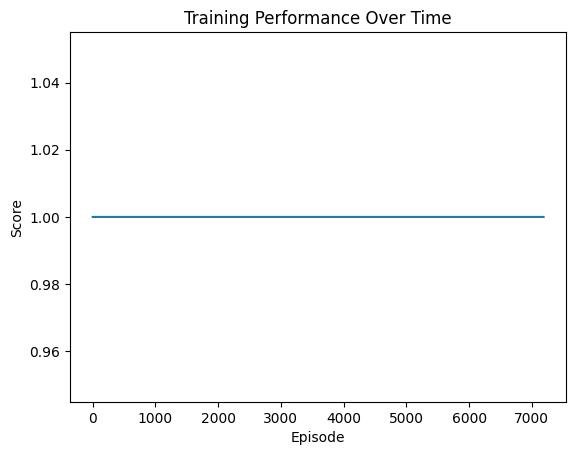

In [ ]:
# Visualisasi hasil training
episodes = len(dataset['Status'])
scores = []
for episode in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        action, _ = ppo.select_action(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    scores.append(score)
    print(f"Episode: {episode}, Score: {score}")

env.close()

# Plotting the scores
plt.plot(range(len(scores)), scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Performance Over Time')
plt.show()


   cpu_usage  memory_usage  bandwidth_inbound  bandwidth_outbound  tps  \
0      0.090         0.535               7.46                6.45  2.0   
1      0.166         0.533               5.85                5.27  2.2   
2      0.202         0.553               9.06                7.96  3.2   
3      0.146         0.580               8.41                7.21  3.2   
4      0.102         0.535               4.88                4.30  2.6   

   tps_error  response_time  Status  
0        0.0          0.607       0  
1        0.0          2.090       0  
2        0.0          3.450       0  
3        0.0          2.580       0  
4        0.0          0.862       0  
     Actual Status  Predicted Status
0                0               1.0
1                0               1.0
2                0               1.0
3                0               1.0
4                0               1.0
..             ...               ...
995              1               1.0
996              0             

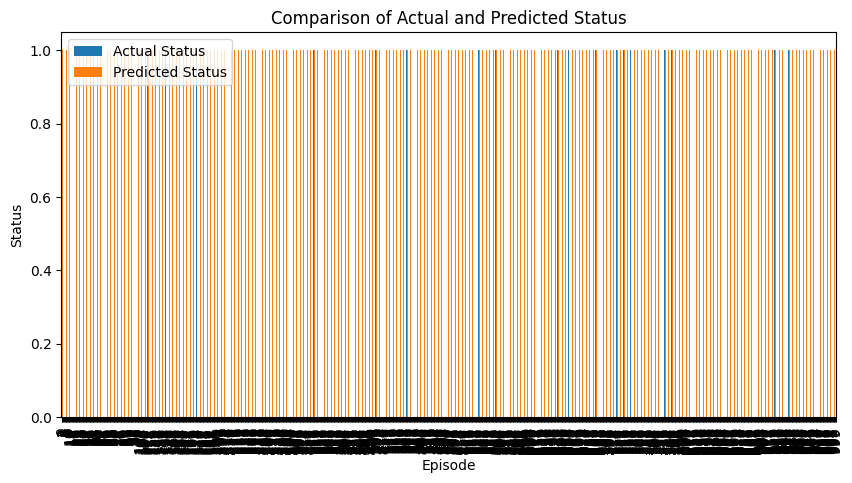

In [ ]:
# Load actual data for comparison
actual_data = dataset
print(actual_data.head())

predicted_statuses = []
actual_statuses = actual_data['Status'].tolist()

def evaluate_and_compare(env, model, n_eval_episodes=10):
    episode_rewards = []
    predicted_statuses = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.select_action(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
            if done:
                predicted_statuses.append(episode_reward)  # Example status: total reward dari episode
        episode_rewards.append(episode_reward)
    return episode_rewards, predicted_statuses

# Evaluasi dan dapatkan predicted status
mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=1000)
_, predicted_statuses = evaluate_and_compare(env, ppo, n_eval_episodes=1000)

# Comparison
comparison_df = pd.DataFrame({
    'Actual Status': actual_statuses[:len(predicted_statuses)],  # Ensure matching length
    'Predicted Status': predicted_statuses
})

print(comparison_df)

# Visualization
comparison_df.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Episode')
plt.ylabel('Status')
plt.title('Comparison of Actual and Predicted Status')
plt.show()
